### Processes images generated from Minecraft screen captures into an HDF5 dataset file

#### Current dataset format

Screenshots are created by teleporting to 3 different world locations:
- **farm**: (-50, 64, 410)
- **forest**: (-273, 65, 782)
- **home**: (-105, 63, 59)

At each location, the pitch is varied to cause the bot to rotate slowly in a circle, and the yaw is chosen randomly at each time step from the interval (-0.20, 0.20) in radians.

The dataset file that is produced by this notebook is in HDF5 format and contains a total of **3600** images. There are **1200** images from each location, and the images are grouped by location in the following order: **farm, forest, home**. Inside each group, the images are shuffled to remove temporal correlations. Each image is a matrix of shape **(1050, 1680, 3)**.

In [1]:
from scipy import ndimage
from scipy.misc import imresize
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

## Example: loading a PNG image

In [2]:
file = "/Users/cosmo/Documents/workspace/screenshot/farm/7.png"
image_sample = ndimage.imread(file)

Check the dimension of the screenshots:

In [3]:
image_sample.shape

(1050, 1680, 3)

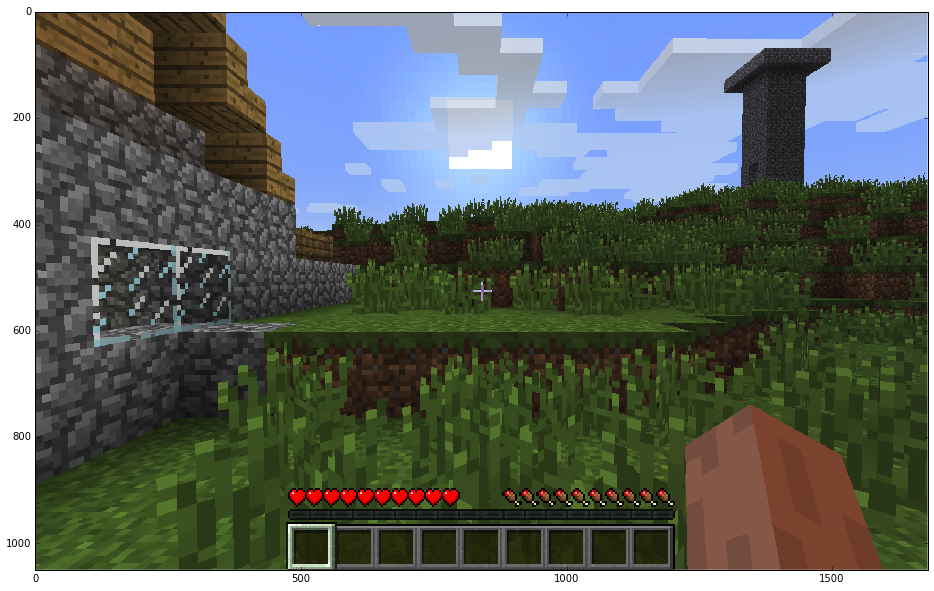

In [4]:
plt.figure(figsize = (16, 10))
plt.imshow(image_sample, interpolation='none');

### Load all of the image files from the screen captures generated in different world regions

#### List of classes that will be added to the dataset

In [5]:
class_names = ['farm', 'forest', 'home']

In [6]:
import glob
filenames = dict()
for class_name in class_names:
    filenames[class_name] = glob.glob('/Users/cosmo/Documents/workspace/screenshot/{0}/*.png'.format(class_name))

#### Shuffle the order of the images to remove the temporal correlation

In [7]:
# np.random.shuffle(farm_files)
# np.random.shuffle(forest_files)
# np.random.shuffle(home_files)

#### Also create a small test list for development purposes

In [8]:
test_files = filenames[class_names[0]][:20]

#### Downsampling the images is possible:

In [9]:
h_scale = 10
v_scale = 10
plt.figure(figsize = (8, 5));
# plt.imshow(imresize(image, (128, 128)), interpolation='none');

If we don't downsample, we have $1680*1050=1764000$ pixels per image. If we downsample by a factor of 5, then we have $336*210=70560$ pixels per image. If we downsample to (128, 128) images then we have 16384 pixels per image.

## Create the HDF5 dataset

In [10]:
import h5py
from fuel.datasets.hdf5 import H5PYDataset

In [11]:
filename = 'minecraft0.1.downsampled.28.28.greyscale.hdf5'
f = h5py.File(filename, mode='w')

#### Load a single image to get the parameters

In [12]:
# We can optionally downsample the images before adding them to the dataset
downsample = True

# We can optionally convert the images to greyscale
greyscale = True

# How many images to add to the dataset in each batch before flushing to disk
batch_size = 100

# Define how much of the dataset to use for training versus testing
training_percent = 0.70

# Assumption: all images have the same size and each class contains the same number of images
test_image = ndimage.imread(filenames['farm'][0])
h, w, num_channels = test_image.shape

# if downsampled, enter the new width and height here
h = 28
w = 28

# if greyscale, has 1 channel instead of 3
if greyscale:
    num_channels = 1

num_images = 0
for cl in filenames:
    num_images += len(filenames[cl])
    
images_per_class = len(filenames['farm'])

In [13]:
h, w, num_channels, num_images, images_per_class, batch_size, downsample

(28, 28, 1, 3600, 1200, 100, True)

#### Create the features and targets datasets

##### Create the features dataset

In [14]:
features = f.create_dataset('features', (num_images, num_channels, h, w), dtype='uint8')

In [15]:
features.shape

(3600, 1, 28, 28)

##### Create the targets dataset

In [16]:
targets = f.create_dataset('targets', (num_images, 1), dtype='int64')  # dtype='uint8'

In [17]:
targets.shape

(3600, 1)

In [18]:
targets

<HDF5 dataset "targets": shape (3600, 1), type "<i8">

#### Load the images into the dataset

Since we have a large number of images to add to the dataset, we divide the work into batches, and flush to disk every 100 images.

In [19]:
# If downsample is True, then we need to define the image size here
image_size = (h, w)

# Calculate how many batches will be needed per class
batches_per_class = int(images_per_class / batch_size)

# For each image class
# for class_idx in range(len(class_names)):
for class_idx, class_name in enumerate(class_names):
    print('Processing class: {0}'.format(class_name))

    # Split this class into batches_per_class batches
    for batch in range(batches_per_class):
        # Compute the offset based on what batch number we are on in order
        # to add the offset to the image index in the vector of images
        offset = batch * batch_size
        for i in range(batch_size):
            if greyscale:
                # Convert to greyscale
                image = np.asarray(Image.open(filenames[class_name][offset + i]).convert("L"))
            else:
                image = ndimage.imread(filenames[class_name][offset + i])
            
            image_index = class_idx * images_per_class + offset + i
            
#             print('image index: {0}'.format(image_index))
            
            if downsample:
                image = imresize(image, image_size)
            
            # Change order of tuple from ('height', 'width', 'channel') 
            # to ('channel', 'height', 'width')
            im_shape = image.shape
            
            if greyscale:
                h, w = image.shape 
                image = image.reshape(1, 1, h, w)
            else:
                image = image.reshape(1, im_shape[2], im_shape[0], im_shape[1])
            
            features[image_index] = image
            
            # Add the class label
#             targets[image_index] = class_idx
            targets[image_index] = class_idx
    
#             print(targets[image_index])
                
        # Write the dataset that has been constructed so far to disk
        f.flush()
        print('Batch #{0}/{1} done.'.format(batch + 1, batches_per_class))

Processing class: farm
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class: forest
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class: home
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.


#### Split into train and test

In [20]:
# make a list of all the indices, and reshape it into 3 classes
indices = np.arange(num_images).reshape((len(class_names), images_per_class))

In [21]:
# shuffle within each class
np.random.shuffle(indices.T)

In [22]:
# compute the number of training examples per class
num_training = int(training_percent * images_per_class)
num_training

840

In [23]:
# choose a subset of the indices in each class for training
# f['train_indices'] = np.concatenate(indices[:, :num_training])
train_indices = np.concatenate(indices[:, :num_training])

In [24]:
train_indices

array([ 411,   59,   18, ..., 2509, 3592, 3133])

In [25]:
# choose a subset of the indices in each class for testing
test_indices = np.concatenate(indices[:, num_training:])

In [26]:
# shuffle within the training and test sets
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

In [27]:
f['train_indices'] = train_indices
f['test_indices'] = test_indices

In [28]:
train_ref = f['train_indices'].ref

In [29]:
test_ref = f['test_indices'].ref

In [30]:
split_dict = {
    'train': {'features': (-1, -1, train_ref),
              'targets': (-1, -1, train_ref)},
    'test':  {'features': (-1, -1, test_ref),
              'targets': (-1, -1, test_ref)},
}

f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [31]:
print(split_dict)
print(f.attrs['split'])

{'test': {'targets': (-1, -1, <HDF5 object reference>), 'features': (-1, -1, <HDF5 object reference>)}, 'train': {'targets': (-1, -1, <HDF5 object reference>), 'features': (-1, -1, <HDF5 object reference>)}}
[(b'test', b'features', -1, -1, <HDF5 object reference>, True, b'.')
 (b'test', b'targets', -1, -1, <HDF5 object reference>, True, b'.')
 (b'train', b'features', -1, -1, <HDF5 object reference>, True, b'.')
 (b'train', b'targets', -1, -1, <HDF5 object reference>, True, b'.')]


#### Annotate the dataset with labels

In [32]:
f['features'].dims[0].label = 'batch'
f['features'].dims[1].label = 'channel'
f['features'].dims[2].label = 'height'
f['features'].dims[3].label = 'width'
f['targets'].dims[0].label = 'batch'
f['targets'].dims[1].label = 'index'

In [33]:
f.flush()
f.close()

### Access the HDF5 dataset we created

In [34]:
from fuel.datasets.hdf5 import H5PYDataset

In [49]:
# filename = 'minecraft0.1.downsampled.hdf5'
filename = 'minecraft0.1.downsampled.28.28.greyscale.hdf5'

In [50]:
size_training_set = H5PYDataset(filename, which_sets=('train',)).num_examples

Split the training set into train_set and valid_set:

In [51]:
num_training = round(2520*.8)
num_validation = size_training_set - num_training
num_training, num_validation

(2016, 504)

In [52]:
train_set = H5PYDataset(filename, which_sets=('train',), subset=slice(0, num_training))

In [53]:
valid_set = H5PYDataset(filename, which_sets=('train',), subset=slice(num_training, size_training_set))

In [54]:
test_set = H5PYDataset(filename, which_sets=('test',))

In [55]:
train_set.num_examples, valid_set.num_examples, test_set.num_examples

(2016, 504, 1080)

We can view the available data sources:

In [56]:
print(train_set.provides_sources)
print(test_set.provides_sources)

('features', 'targets')
('features', 'targets')


In [57]:
print(train_set.axis_labels['features'])
print(train_set.axis_labels['targets'])
print(test_set.axis_labels['features'])
print(test_set.axis_labels['targets'])

('batch', 'channel', 'height', 'width')
('batch', 'index')
('batch', 'channel', 'height', 'width')
('batch', 'index')


In [58]:
handle = train_set.open()

#### Load a small slice from each subset of the data and look at the resulting images

In [59]:
from PIL import Image
import matplotlib.cm as cm

In [60]:
data = train_set.get_data(handle, slice(0, train_set.num_examples))

In [61]:
data[0].shape

(2016, 1, 28, 28)

In [62]:
data[1].dtype

dtype('int64')

In [75]:
# todo: is this correct?
im_shape = data[0].shape
im_shape

(2016, 1, 28, 28)

In [76]:
# greyscale = True
# if greyscale:
#     images = data[0].reshape(im_shape[0], im_shape)
# else:
# images = data[0].reshape(im_shape[0], im_shape[2], im_shape[3], im_shape[1])

In [79]:
# todo: fix this
images = images.reshape(2016, 28, 28)

In [80]:
images[0].shape

(28, 28)

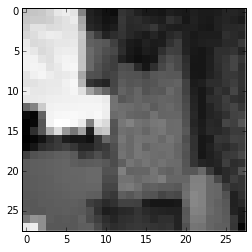

In [81]:
plt.imshow(images[0], interpolation='none', cmap=cm.Greys_r);

#### Visualize some random images from the training set

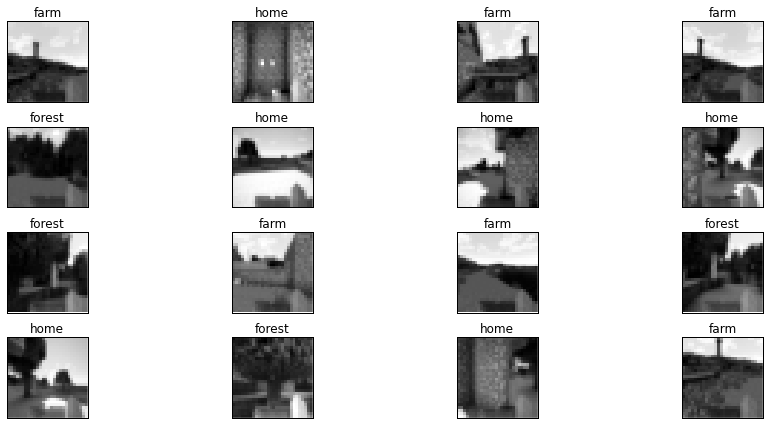

In [84]:
fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k');
class_names = ['farm', 'forest', 'home']
for i in range(4):
    for j in range(4):
        idx = np.random.randint(train_set.num_examples)
        ax = fig.add_subplot(4,4,i*4+j+1);
        if greyscale:
            ax.imshow(images[idx], interpolation='none', cmap=cm.Greys_r)
        else:
            ax.imshow(images[idx], interpolation='none');
        ax.set_title(class_names[data[1][idx][0]]);
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
fig.tight_layout();

In [83]:
train_set.close(handle)
valid_set.close(handle)
test_set.close(handle)

In [ ]:
fname = '/Users/cosmo/Documents/workspace/screenshot/farm/7.png'

image = np.asarray(Image.open(fname).convert("L"))
plt.imshow(image, cmap = cm.Greys_r)
plt.show()

In [ ]:
data[0].max()